It is an unexpected result for the transcriptomics to outperform the proteomics, as we would expect for the most part, proteins to be closer to phenotype and mechanism than RNA. 

Here, we hypothesize that this may be due to the fact that transcriptomics covers a larger fraction of the genome than proteomics, resulting in more comprehensive coverage, including geneds more informative of metastatic mechanisms. This may be likely for two reasons: 1) the transcriptomics didn't outperform the proteomics too strongly (by MSE effect size and few significant comparisons in Pearson), and 2) the proteomics gained its performance with a small subset of total features, whereas transcriptomics required all features.

In the previous notebook, we down-samples the sumple numbers of the transcriptomics as a comparison. Here, we will also downsample the transcriptomic features to that of the protein dataset to see how this effects model performance. 

In [53]:
import os
import json
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object, cohen_d

In [54]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 1024

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

# 0. Map Features

Load the files:

In [57]:
# protein
expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
protein_cols = expr_protein.columns

mp_protein = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)

X_protein = expr_protein.values
y_protein = mp_protein['mean'].values.ravel()

# rna
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)
rna_cols = expr_rna.columns
mp_rna = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)

X_rna = expr_rna.values
y_rna = mp_rna['mean'].values.ravel()


In [58]:
# map from uniprot ID to gene name
# uniprot_ids = list(set([protein_id.split('|')[1].split('-')[0] for protein_id in protein_cols]))
# mg = mygene.MyGeneInfo()
# uid_maps = mg.querymany(uniprot_ids, scopes="uniprot", fields="symbol", species="human")
# uid_mapper = {pn.get('query'): pn.get('symbol', np.nan) for pn in uid_maps}
# with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "w") as json_file:
#     json.dump(uid_mapper, json_file, indent=4)
with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "r") as json_file:
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
'P16189': 'HLA-A',
'P30456': 'HLA-A',
'P30443': 'HLA-A',
'P05534': 'HLA-A',
'P18462': 'HLA-A',
'P01892': 'HLA-A',
'P13746': 'HLA-A',
'P01891': 'HLA-A',
'P30483': 'HLA-B',
'P30484': 'HLA-B',
'P03989': 'HLA-B',
'P30460': 'HLA-B',
'P30461': 'HLA-B',
'Q95365': 'HLA-B',
'P16188': 'HLA-A',
'Q95604': 'HLA-C',
'Q07000': 'HLA-C',
'P30499': 'HLA-C',
'P30501': 'HLA-C',
'P30504': 'HLA-C',
'Q95IE3': 'HLA-DRB1',
'P04229': 'HLA-DRB1',
'P20039': 'HLA-DRB1',
'P13760': 'HLA-DRB1',
'Q5Y7A7': 'HLA-DRB1',
'Q9GIY3': 'HLA-DRB1',
'Q9TQE0': 'HLA-DRB1',
'Q30134': 'HLA-DRB1'}
    
protein_names = []
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names.append(gene_name)
# n_protein_names = len(set(protein_names))

In [59]:
rna_names = [rna_id.split(' (')[0] for rna_id in rna_cols]
# protein_names = [protein_id.split('|')[-1].split('_HUMAN')[0] for protein_id in protein_cols]
intersect_names = set(rna_names).intersection(protein_names)

n_features = [len(rna_names), len(protein_names), len(intersect_names)]
print('Of the {} RNA features and {} protein features, there are {} features in common'.format(*n_features))

rna_map = dict(zip(rna_cols, rna_names))
protein_map = dict(zip(protein_cols, protein_names))

Of the 19138 RNA features and 10969 protein features, there are 10291 features in common


# 1. Top Transcriptomics Features

First, let's see how many of the top transcriptomic features are present in the proteomic dataset, as well as how the rankings compare to the features selected in the proteomics model. The expectation is, that if our hypothesis is true, the top transcriptomic features are ones that are not present in proteomics (and thus, proteomics is just missing measurement of genes that are informative of metastasis).  

For proteomics, since there was no significant differences between consensus models from [notebook 03](./03_predict_proteomics.ipynb) and since only the linear SVR and RBF SVR outperformed all random baselines, and since linear SVR makes this more directly comparable to transcriptomics, we proceed with it. This consensus model had only 1000 features selected.

For feature comparisons, we re-fit the consensus models on the entire datasets (no train/test splits). 

Load and fit the models:

In [60]:
# protein
best_pipeline_protein = read_pickled_object(os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))
best_pipeline_protein.fit(X_protein, y_protein)

# rna
best_pipeline_rna = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline_rna.fit(X_rna, y_rna)

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=19138)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(0.12405950756148096),
                     epsilon=np.float64(0.7247779323323353),
                     kernel='linear'))])

In [61]:
model_coefs_protein = best_pipeline_protein.named_steps['model'].coef_.flatten()
protein_indices = best_pipeline_protein.named_steps['feature_reduction'].top_indices_
selected_protein_cols = [protein_cols[i] for i in protein_indices]

model_coefs_protein = pd.DataFrame(data = {'SVM coefficient': model_coefs_protein},
                                   index = selected_protein_cols)
model_coefs_protein['Gene_Name'] = model_coefs_protein.index.map(protein_map)
model_coefs_protein.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs_protein.reset_index(names = 'feature', inplace = True)
selected_protein_genes = set(model_coefs_protein.Gene_Name)
# n_selected_protein_genes = len(selected_protein_genes)

In [62]:
model_coefs_rna = best_pipeline_rna.named_steps['model'].coef_.flatten()
rna_indices = best_pipeline_rna.named_steps['feature_reduction'].top_indices_
selected_rna_cols = [rna_cols[i] for i in rna_indices]

model_coefs_rna = pd.DataFrame(data = {'SVM coefficient': model_coefs_rna},
                                   index = selected_rna_cols)
model_coefs_rna['Gene_Name'] = model_coefs_rna.index.map(rna_map)
model_coefs_rna.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs_rna.reset_index(names = 'feature', inplace = True)

model_coefs_rna['in_protein_all'] = False
isin_protein = model_coefs_rna[model_coefs_rna.Gene_Name.isin(protein_names)].index
model_coefs_rna.loc[isin_protein, 'in_protein_all'] = True
model_coefs_rna['in_protein_all'] = pd.Categorical(model_coefs_rna.in_protein_all, 
                                              ordered = True, 
                                              categories = [True, False])

model_coefs_rna['in_protein_selected'] = False
isin_protein = model_coefs_rna[model_coefs_rna.Gene_Name.isin(selected_protein_genes)].index
model_coefs_rna.loc[isin_protein, 'in_protein_selected'] = True
model_coefs_rna['in_protein_selected'] = pd.Categorical(model_coefs_rna.in_protein_selected, 
                                              ordered = True, 
                                              categories = [True, False])


In [63]:
model_coefs_rna['fraction_overlap_all'] = np.nan
model_coefs_rna['fraction_overlap_selected'] = np.nan
for rank in tqdm(model_coefs_rna.index):
    ffa = model_coefs_rna.loc[:rank, 'in_protein_all'].value_counts()[True]/(rank + 1)
    model_coefs_rna.loc[rank, 'fraction_overlap_all'] = ffa
    
    ffs = model_coefs_rna.loc[:rank, 'in_protein_selected'].value_counts()[True]/(rank + 1)
    model_coefs_rna.loc[rank, 'fraction_overlap_selected'] = ffs

100%|██████████████████████████████████████████████████| 19138/19138 [00:30<00:00, 620.21it/s]


In [64]:
viz_df = model_coefs_rna.copy()
viz_df['rank'] = [i +1 for i in viz_df.index.tolist()]

''

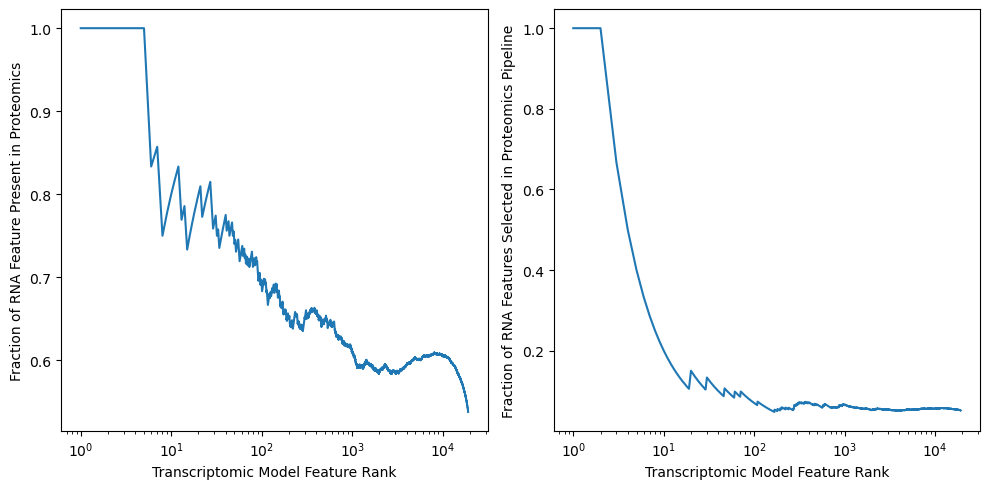

In [133]:
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)

viz_df = model_coefs_rna.copy()
viz_df['rank'] = [i +1 for i in viz_df.index.tolist()]


sns.lineplot(data = viz_df, x = 'rank', y = 'fraction_overlap_all', ax = ax[0])
ax[0].set_xscale('log')
ax[0].set_ylabel('Fraction of RNA Feature Present in Proteomics')
ax[0].set_xlabel('Transcriptomic Model Feature Rank')

sns.lineplot(data = viz_df, x = 'rank', y = 'fraction_overlap_selected', ax = ax[1])
ax[1].set_xscale('log')
ax[1].set_ylabel('Fraction of RNA Features Selected in Proteomics Pipeline')
ax[1].set_xlabel('Transcriptomic Model Feature Rank')

fig.tight_layout()

plt.savefig(os.path.join(data_path, 'figures', 'intersection_rank.png'), 
            dpi=300, 
            bbox_inches="tight")  
;

Using the consensus transcriptomics linear SVR model for the feature ranks:
    
On the left panel, we see the fraction of transcriptomic features at that rank that are present in proteomics. If our hypothesis is true, we would expect that at higher ranks, there would be fewer features present in transcriptomics than at lower ranks. 

Here, the overall trend indicates the opposite of our hypothesis: those features most important for the transcriptomics model are in fact present in the proteomics dataset. However, it is important to keep in mind that this can be more nuanced: for example, in the top 5-100 features, the overlap drops from 100% to ~70%. It is possible that that missing 30% of features makes all the difference. 

On the right panel, we see the fraction of transcriptomic features at that rank that are present in the 1000 selected proteomic features used for the consensus proteomic models. This nuanced point is now exacerbated: by the time we reach the top 10-100 features, hardly any of them are present in those selected for proteomics. 

In [131]:
viz_df.head(10)

,feature,SVM coefficient,Gene_Name,in_protein_all,in_protein_selected,fraction_overlap_all,fraction_overlap_selected,rank
0,MME (4311),0.013671,MME,True,True,1.000000,1.000000,1
1,C15orf48 (84419),-0.010944,C15orf48,True,True,1.000000,1.000000,2
2,ITGA6 (3655),0.010902,ITGA6,True,False,1.000000,0.666667,3
3,ZSCAN18 (65982),-0.010808,ZSCAN18,True,False,1.000000,0.500000,4
4,HLA-DRB1 (3123),0.010545,HLA-DRB1,True,False,1.000000,0.400000,5
5,KRT20 (54474),-0.009573,KRT20,False,False,0.833333,0.333333,6
6,HLA-DPB1 (3115),0.009516,HLA-DPB1,True,False,0.857143,0.285714,7
7,IL32 (9235),-0.009450,IL32,False,False,0.750000,0.250000,8
8,BCHE (590),-0.009282,BCHE,True,False,0.777778,0.222222,9
9,LPAR1 (1902),-0.009281,LPAR1,True,False,0.800000,0.200000,10


In [132]:
viz_df.fraction_overlap_all.head(100)

0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
        ...   
95    0.697917
96    0.690722
97    0.693878
98    0.696970
99    0.690000
Name: fraction_overlap_all, Length: 100, dtype: float64

# 2. Intersection with Proteomic Features

Here, we re-run our prediction pipeline, starting again from hyperparameter tuning. We proceed with the linear SVRs as explained above. However, to make the comparison fair, in this case, for both transcriptomics and proteomics, we start with the intersection of features. Furthermore, we only use the samples in common between the two (similar to the power analysis).

In [66]:
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import optuna
from optuna.samplers import CmaEsSampler, TPESampler, RandomSampler

from utils import FeatureSelector, MeanCenterer, HybridSampler, RandomTPESampler

## 2.0: Map samples between proteomics and transcriptomics:

In [67]:
md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr_protein.index = pd.Series(expr_protein.index).apply(lambda x: x.split('_')[0])

sample_mapper = md[md.StrippedCellLineName.isin(expr_protein.index)]
sample_mapper = dict(zip(sample_mapper.StrippedCellLineName, sample_mapper.index))
if len(sample_mapper) != expr_protein.shape[0]:
    raise ValueError('Expect all samples to be mapped')
expr_protein.index = expr_protein.index.map(sample_mapper)
mp_protein.index = expr_protein.index

with open(os.path.join(data_path, 'processed', 'proteomics_sample_mapper.json'), "w") as json_file:
    json.dump(sample_mapper, json_file, indent=4)

In [68]:
common_samples = sorted(set(expr_protein.index).intersection(expr_rna.index))
print('Of the {} and {} samples in protein and RNA datasets, respectively, {} are shared'.format(expr_protein.shape[0], 
                                                                                                expr_rna.shape[0], 
                                                                                                len(common_samples)))

Of the 248 and 481 samples in protein and RNA datasets, respectively, 247 are shared


In [69]:
expr_protein_common = expr_protein.loc[common_samples, :]
expr_rna_common = expr_rna.loc[common_samples, :]
mp_common = mp_protein.loc[common_samples, :]

y_common = mp_common['mean'].values.ravel()

## 2.1: Hyperparameter tuning

This is conducted on all samples available to each dataset, as previously described in notebooks A/02 and B/02: 

In [70]:
intersect_genes = set(rna_names).intersection(protein_names)

rna_cols_intersect = [rna_cols[i] for i, rna_name in enumerate(rna_names) if rna_name in intersect_genes]
protein_cols_intersect = [protein_cols[i] for i, protein_name in enumerate(protein_names) if protein_name in intersect_genes]

n_protein_features = len(protein_cols_intersect) 
n_rna_features = len(rna_cols_intersect)
if n_protein_features != n_rna_features:
    msg = 'Due to a lack of 1-to-1 mapping between protein and RNA features, '
    msg += 'taking the intersection between them results in {} '.format(n_protein_features)
    msg += 'protein features and {} RNA features'.format(n_rna_features)
    print(msg)
    print('')
    
    msg = 'Compare this to the starting amount of features for each: '
    msg += ' {} and {} for protein and RNA, respectively'.format(len(protein_cols), len(rna_cols))
    print(msg)


Due to a lack of 1-to-1 mapping between protein and RNA features, taking the intersection between them results in 10649 protein features and 10291 RNA features

Compare this to the starting amount of features for each:  10969 and 19138 for protein and RNA, respectively


In [71]:
def optuna_objective(trial, X, y, inner_cv, n_cores, random_state):
    model_type = 'SVR_linear'
    
    # Define feature reduction/selection method
        
    steps = [
        ("feature_reduction", FeatureSelector(method="top_n_cv", 
                                              n_features=trial.suggest_categorical("FeatureSelector__n_features", [250, 500, 1000, 5000, X.shape[1]]))),
        ("mean_centering", MeanCenterer()),
    ]

    steps.append(("model", SVR(
        kernel='linear',
        C=trial.suggest_float(model_type + "__C", 1e-4, 1e2, log = True),
        epsilon=trial.suggest_float(model_type + "__epsilon", 1e-3, 10, log=True)
    )))

    # Create the pipeline
    pipeline = Pipeline(steps)

    # Evaluate with cross-validation
    mse = -cross_val_score(pipeline, X, y, 
                           cv=inner_cv, 
                           scoring="neg_mean_squared_error", 
                           n_jobs=inner_cv.n_splits).mean()

    return mse

def generate_best_pipeline(study):
    best_params = study.best_params
    steps = []
    steps.append(("feature_reduction", FeatureSelector(method="top_n_cv", n_features=best_params["FeatureSelector__n_features"])))
    steps.append(("mean_centering", MeanCenterer()))
    
    steps.append(("model", SVR(
        kernel='linear',
        C=best_params["SVR_linear__C"],
        epsilon=best_params['SVR_linear__epsilon']
    )))
    best_pipeline = Pipeline(steps)
    return best_pipeline


In [72]:
X_protein = expr_protein_common[protein_cols_intersect].copy().values
X_rna = expr_rna_common[rna_cols_intersect].copy().values


outer_folds=10
inner_folds=5
n_trials = 100

In [73]:
cmaes_sampler = CmaEsSampler(seed=random_state, 
                             warn_independent_sampling=False, 
                            restart_strategy='bipop')

exploration_sampler = RandomSampler(seed=random_state)
tpe_sampler = RandomTPESampler(seed=random_state, 
                               n_startup_trials = 15,
                               exploration_sampler = exploration_sampler, 
                               exploration_freq=20 # randomly sample every n trials
                              )

/nobackup/users/hmbaghda/Software/miniforge3/envs/metastatic_potential/lib/python3.13/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``restart_strategy`` is an experimental feature. The interface can change in the future.
  warnings.warn(


In [134]:
# outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
# inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)

# results = []
# res_df = None

# for k, (train_idx, test_idx) in enumerate(outer_cv.split(X_protein, y_common)):
#     print(k)
#     y_train, y_test = y_common[train_idx], y_common[test_idx]

#     X = {'Proteomics': {}, 
#         'Transcriptomics': {}}

#     X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
#     X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]

#     for modality in X:
#         pruner = optuna.pruners.SuccessiveHalvingPruner()
#         study = optuna.create_study(direction="minimize", 
#                                     sampler=HybridSampler(primary_sampler=cmaes_sampler, fallback_sampler=tpe_sampler), 
#                                    pruner = pruner, 
#                                    study_name = '{}_optuna'.format(k))
#         study.optimize(
#             lambda trial: optuna_objective(trial, X[modality]['train'], y_train, inner_cv, n_cores, random_state),
#             n_trials=n_trials, 
#             catch=(ValueError,)
#         )
        
#         best_pipeline = generate_best_pipeline(study)
#         best_pipeline.fit(X[modality]['train'], y_train)

#         y_train_pred = best_pipeline.predict(X[modality]['train'])
#         y_test_pred = best_pipeline.predict(X[modality]['test'])

#         train_corr = pearsonr(y_train, y_train_pred)[0]
#         test_corr = pearsonr(y_test, y_test_pred)[0]
#         train_mse = mean_squared_error(y_train, y_train_pred)
#         test_mse = mean_squared_error(y_test, y_test_pred)
        
#         results.append({
#             "modality": modality,
#             "fold": k,
#             "train_corr": train_corr,
#             "test_corr": test_corr,
#             "train_mse": train_mse,
#             "test_mse": test_mse,
#             "best_params": study.best_params,
#             "inner_cv": study.trials_dataframe()
#             })
#         res_df = pd.DataFrame(results)
#         res_df.to_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv'))


res_df = pd.read_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv'), 
                    index_col = 0)
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])

In [135]:
r_res = res_df[res_df.modality == 'Transcriptomics']
p_res = res_df[res_df.modality == 'Proteomics']

In [136]:
for x in r_res.best_params:
    print(eval(x)['FeatureSelector__n_features'])

5000
5000
10291
5000
10291
10291
10291
5000
5000
10291


In [137]:
for x in p_res.best_params:
    print(eval(x)['FeatureSelector__n_features'])

10649
10649
500
10649
500
10649
1000
1000
1000
1000


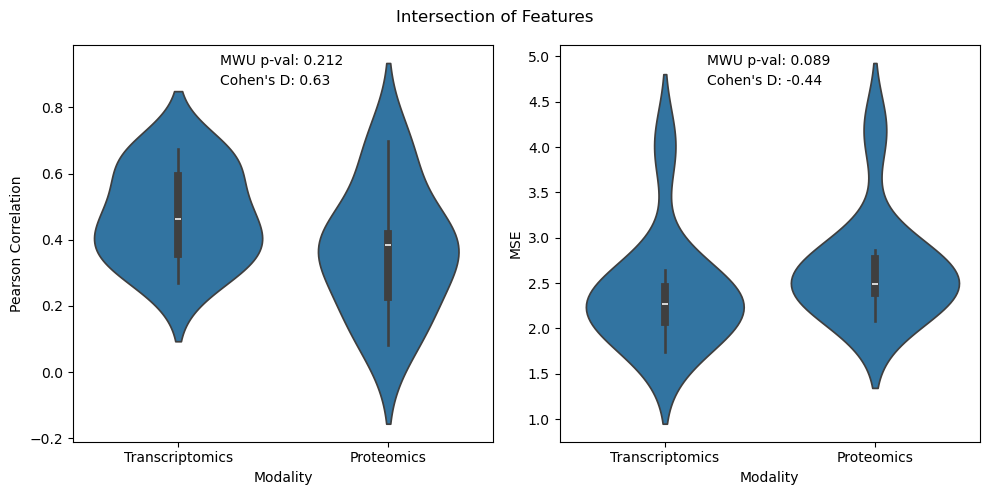

In [138]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))

for i, metric in enumerate(metric_types):    
    sns.violinplot(data = res_df, x = 'modality', y = 'test_' + metric, ax = ax[i])
    
    pval = stats.mannwhitneyu(r_res['test_' + metric], p_res['test_' + metric]).pvalue
    cd = cohen_d(r_res['test_' + metric], p_res['test_' + metric])
    
    ax[i].annotate("MWU p-val: {:.3f}".format(pval), xy=(0.35, 0.95), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.35, 0.9), xycoords='axes fraction')
    
    ax[i].set_xlabel('Modality')
    ax[i].set_ylabel(mmap[metric])
    
fig.suptitle('Intersection of Features')

plt.savefig(os.path.join(data_path, 'figures', 'intersection_intersectioncomparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

fig.tight_layout()

Let's ensure that, in contrast, on these 10-folds but each data modality using all features, the power analysis results demonstrating transcriptomics outperforms proteomics holds:

In [144]:
best_pipeline_rna = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline_protein = read_pickled_object(os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))

X_rna = expr_rna_common.values
X_protein = expr_protein_common.values

In [145]:
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
results = []
res_df = None


for k, (train_idx, test_idx) in enumerate(outer_cv.split(X_protein, y_common)):
    y_train, y_test = y_common[train_idx], y_common[test_idx]

    X = {'Proteomics': {}, 
        'Transcriptomics': {}}

    X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
    X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]
    
    for modality, best_pipeline in best_pipeline_modality.items():
        best_pipeline.fit(X[modality]['train'], y_train)

        y_train_pred = best_pipeline.predict(X[modality]['train'])
        y_test_pred = best_pipeline.predict(X[modality]['test'])

        train_corr = pearsonr(y_train, y_train_pred)[0]
        test_corr = pearsonr(y_test, y_test_pred)[0]
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        results.append({
            "modality": modality,
            "fold": k,
            "train_corr": train_corr,
            "test_corr": test_corr,
            "train_mse": train_mse,
            "test_mse": test_mse,
            })
        res_df = pd.DataFrame(results)
        
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])

In [146]:
r_res = res_df[res_df.modality == 'Transcriptomics']
p_res = res_df[res_df.modality == 'Proteomics']

In [147]:
r_res.test_corr.std()

np.float64(0.14544354803451268)

In [148]:
p_res.test_corr.std()

np.float64(0.22107757826036575)

In [149]:
r_res.test_mse.std()

np.float64(0.5920904038818691)

In [150]:
p_res.test_mse.std()

np.float64(0.6544638071607589)

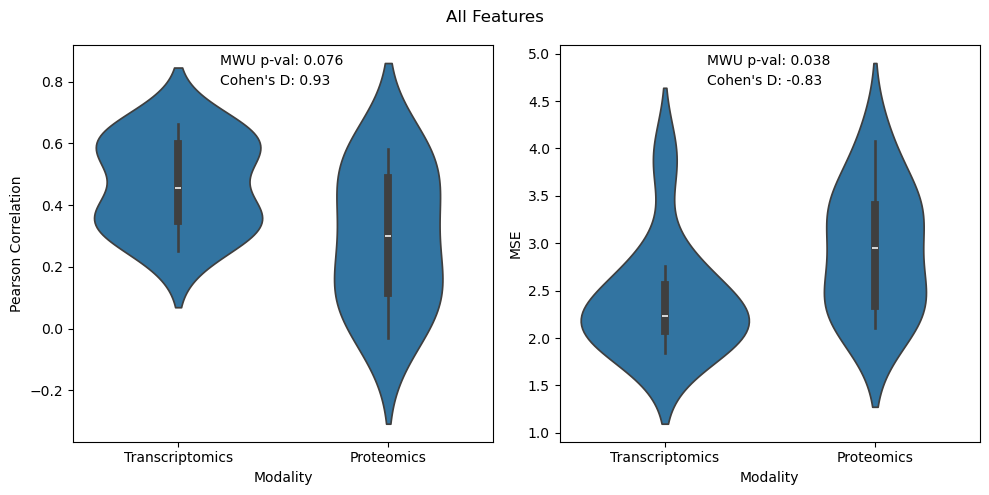

In [142]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))


for i, metric in enumerate(metric_types):    
    sns.violinplot(data = res_df, x = 'modality', y = 'test_' + metric, ax = ax[i])
    
    pval = stats.mannwhitneyu(r_res['test_' + metric], p_res['test_' + metric]).pvalue
    cd = cohen_d(r_res['test_' + metric], p_res['test_' + metric])
    
    ax[i].annotate("MWU p-val: {:.3f}".format(pval), xy=(0.35, 0.95), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.35, 0.9), xycoords='axes fraction')
    
    ax[i].set_xlabel('Modality')
    ax[i].set_ylabel(mmap[metric])
    
fig.suptitle('All Features')
plt.savefig(os.path.join(data_path, 'figures', 'intersection_unionncomparison.png'), 
            dpi=300, 
            bbox_inches="tight")  
fig.tight_layout()

In [143]:
os.path.join(data_path, 'figures')

'/nobackup/users/hmbaghda/metastatic_potential/figures'